In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [78]:
X,y = mnist['data'], mnist['target']
X.shape # Images features total 784 i.e 28x28 pixel images each feature then represent the pixel intensity of each picture.
y.shape #the corresponding name of the image i.e our target.
X = X.to_numpy()
y = y.to_numpy()
y[0]

'5'

6


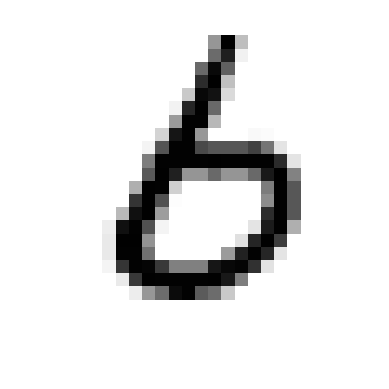

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
def image_plotter(n, dataframe):
    print(y[n])
    some_digit = dataframe[n]
    some_digit_image = np.array(some_digit).reshape(28, 28)
    plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
    plt.axis("off")
    plt.show()
image_plotter(5998, X)
#As seen the label tells us that it is a five an d indeed we do see a five. 

In [79]:
#now the labels are strings and we would very much prefer integer values so...
y = y.astype(np.uint8)

In [6]:
# but wait we must plit this into trining and test set, but the mnist dataset has already split the sata for us, first 60,000 train set and last 10,000 test so..
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
#now lets simplify this data a little only the digit 5 so we'll train a binary classifier i.e 5 or not 5
y_train_5 = (y_train == 5) # a boolean matric representing true if label is 5 and false otherwise
y_test_5 = (y_test == 5)


In [8]:
#Now let use an SGDClassifier 
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
some_data = X_train[2]
sgd_clf.predict([some_data])

array([False])

In [10]:
#now evaluating the model note: **Evaluating a classifier is often significantly trickier than evaluating a regressor**
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
#now dote that X_train refers to the features data and y_train referes to the labels data
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle = True)#creates a skfold random splitter basically
for train_index, test_index in skfolds.split(X_train, y_train_5):# uses that to do the slitting note that there are going to be 3 different splits(folds)
    clone_clf = clone(sgd_clf) # clone the model
    X_train_folds = X_train[train_index]#obtain the table of features for each fold for the training of the model
    y_train_folds = y_train_5[train_index]#obtain the table of labels for each fold for the supervised training of the model
    X_test_fold = X_train[test_index]##obtain the table of features for each fold for the testing of the model
    y_test_fold = y_train_5[test_index]#obtain the table of labels for each fold for the testing of the model
    clone_clf.fit(X_train_folds, y_train_folds)#Train the model with the train fold.
    y_pred = clone_clf.predict(X_test_fold)#run the predictions with the test folds
    n_correct = sum(y_pred == y_test_fold)# Evaluate the predictions vs the labels
    print(n_correct / len(y_pred))#return the ratio of correctness

0.9669
0.91625
0.96785


In [11]:
# or...... just use this:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.95035, 0.96035, 0.9604 ])

In [12]:
#Wow! Above 93% accuracy (ratio of correct predictions) on all cross-validation folds? 
#This looks amazing, doesn’t it? Well, before you get too excited, let’s look at a very
#dumb classifier that just classifies every single image in the “not-5” class:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
#ok ok I grab so this model guesses that all the numbers are not five ; np.zeros((len(X), 1), dtype=bool) 

In [13]:
#now lets test this dumb model performance:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
#Now this model is still about 90&% accurate despite the fact that it learned nothing from thr data and assumes no number in the data is 5
#this is because only about 10% of the data is actually 5 so if you guess that all are not 5 you'll be correct 90% of time.
#This demonstrates why accuracy is generally not the preferred performance measure
#for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).

array([0.91125, 0.90855, 0.90915])

In [14]:
#A much better way to evaluate the performance of a classifier is to look at the confusion matrix. this plots the predicted vs the actual in a tabular manner
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred) # plot a table of the actual labels vs the predicted ones.
#[true negatives(not 5), false positives (not five but predicted as 5)],
#[false negatives(5 but predicted as not 5), true positives(true 5)]

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [16]:
#ok ok now we have a matrix we want a more precise value that summarizes what the table tells us.. well there are 2 ways to do that
#PRECISION and RECALL
#precision = TP/(TP + FP)
#recall = TP/(TP + FN)
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred) 
print(precision, recall)
#now when this model says an image is 5, it is only correct precision(83.7%) amount f times and it only detects recall(65.1%)% of the 5s

0.8370879772350012 0.6511713705958311


In [17]:
# now there's a trade off i.e the higher the precision , the lower the recall and vice versa
#lets see what i'm saying
some_digit = X_train[0]
y_scores = sgd_clf.decision_function([some_digit])
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred
#explanation:
#    y_some_digit_pred = (y_scores > threshold): This line applies the threshold to the decision score (y_scores)
#    for the some_digit sample. If the decision score is greater than the threshold (2100 in this case), 
#    the prediction for some_digit will be True, otherwise, it will be False.
#    That is your classifier detects that the image is a 5 when the theshold is  0 but misses it when it is 2100. now then , how do you set a threshold 

array([ True])

In [18]:
#To set the treshold, we'll be using the cross val predict function again but this time we'll be specifying that we want to return decision scores instead of predictions:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [19]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [20]:
#Now with these scores you can compute precision and recall for all possible thresholds using the precision_recall_curve() function:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

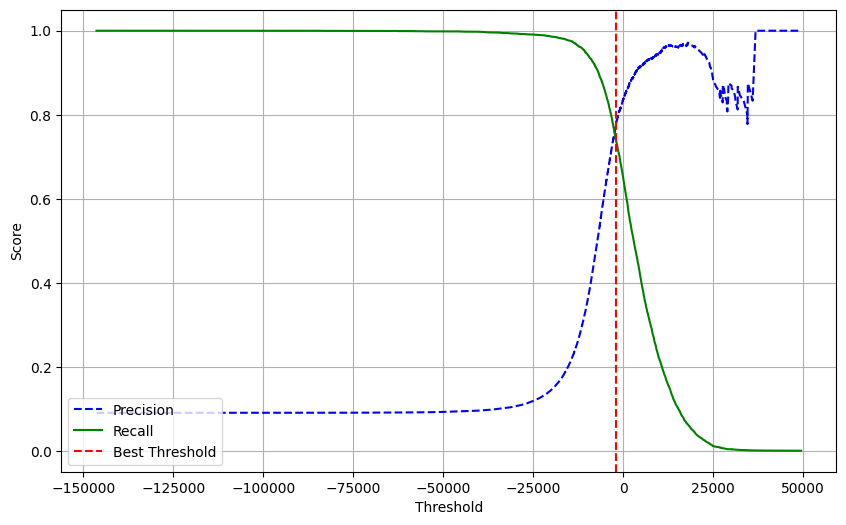

In [21]:
#Finally, you can plot precision and recall as functions of the threshold value using Matplotlib
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

    # Highlight the threshold with a red vertical line
    best_threshold_idx = np.argmax(precisions[:-1] + recalls[:-1])
    best_threshold = thresholds[best_threshold_idx]
    plt.axvline(x=best_threshold, color='r', linestyle='--', label='Best Threshold')

    # Add legend, axis labels, and grid
    plt.legend(loc="lower left")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.grid(True)

# Assuming you have precisions, recalls, and thresholds already defined or calculated
# precisions, recalls, thresholds = your_function_to_calculate_precision_recall_curve()
plt.figure(figsize=(10, 6))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()
#From this plot, you notice that as the threshold increases, the precision drops, so you might want to select the best threshold based
#on the project at hand, if yo want a hight precision, but a low recall you can do that by following the next cell, and vice versa.

In [22]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]#obtain the thresold whose precision is graeter than 90%
y_train_pred_90 = (y_scores >= threshold_90_precision)#Obtain the labels for a 90% accuracy
precision_90 = precision_score(y_train_5, y_train_pred_90)
recall_90 = recall_score(y_train_5, y_train_pred_90)
print(precision_90, recall_90)
#As seen, a 90% precision leaves us with a 48% recall

0.9000345901072293 0.4799852425751706


In [23]:
#But then a recall that low? mening out of 100 5s our model will only detect about 48 of them though those 48 are 90% guaranteed to be 5s
#but what is to become of the rest 52 "5s"  well that s why; If someone says “let’s reach 99% precision,” you should ask, “at what recall?”
#Another way to decide our treshold is to use the ROC curve which plots the true positive(recall, sensitivity) vs the false positive(specificity)
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

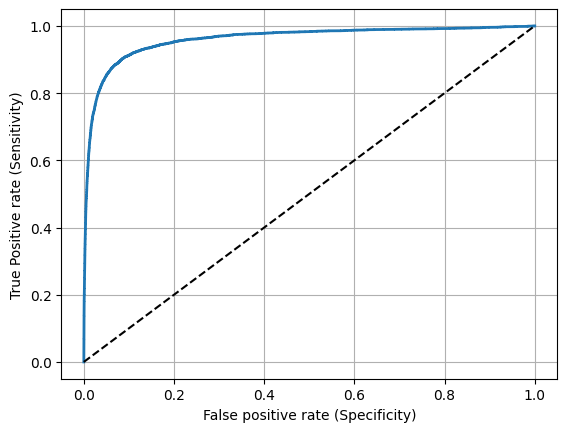

In [24]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel("False positive rate (Specificity)")
    plt.ylabel("True Positive rate (Sensitivity)")
    plt.grid(True)

plot_roc_curve(fpr, tpr)
plt.show()


In [25]:
#So what does thsi tell us?
#One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, 
#whereas a purely random classifier will have a ROC AUC equal to 0.5.
#So here's how to obtain the ROC AUC of our curve:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)
#Don't be too glad, this is only very high because the there are few 5s compared to the non-5s so using a PR curve in this case tells us more.


0.9604938554008616

In [26]:
#Now lets train a random forest classifier and compare our outcomes
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,method="predict_proba")
#Also note that this classifier returns the probability that each instance belongs to the given class (in the case of this example how likely is this image a 5?)

In [27]:
#Now to plot the ROC we need scores not probabilities so...
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class(this array is divided into probability of false and probability of tru so... pick true only)
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

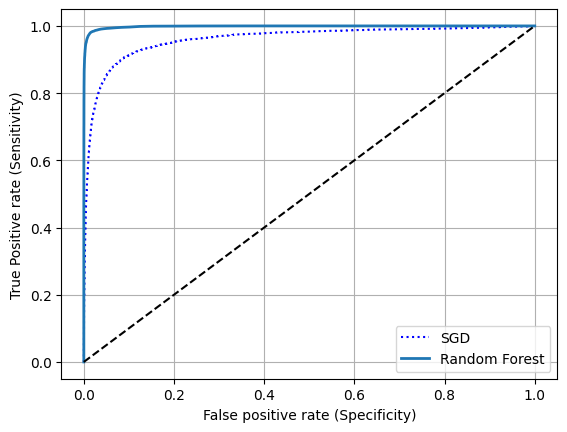

In [28]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest,"Random Forest")
plt.legend(loc="lower right")
plt.show()


In [29]:
#As you can see in the above plot, the RandomForestClassifier’s ROC curve looks much
#better than the SGDClassifier’s: it comes much closer to the top-left corner. As a
#result, its ROC AUC score is also significantly better:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [30]:
y_train_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,method="predict")

In [31]:
#Wow that's great! now lets measure our accuracy and precision score:
precision_score(y_train_5, y_train_forest)
recall_score(y_train_5, y_train_forest)

0.8662608374838591

In [32]:
#Now we are done with binary classifiers, so now we want to move to multinomial classifiers, as I have predicted, one cal train various models
#on every available class and then run the feature of the picture to be predicted accross all the classes an whichever class has the highest 
#prediction score, teakes the win as the true class this is call the OvA (one v All) approach.
#There's also the approach of training one model againt another i.e (1 againt 0), (0 against 2), (1 against 2) and so on... this is know as the OvO approach
#mainly used by the support vector machine classification (SVM classifiers) these guys dont support multinomial classification normally.

In [33]:
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5 we are now training a multinomial model(sounds good 😂)
#Just like that? well apparently '🤣🤣🤣🤣' hehe

SGDClassifier(random_state=42)

[3]
3


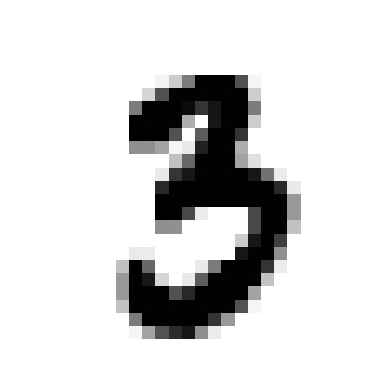

In [34]:
n = 890
some_data = X_train[n]
pred = sgd_clf.predict([some_data])
print(pred)
image_plotter(n, X_train)
#Don't mind me I'm just admiring the work done so far.

In [35]:
#we can actually force sk learn to use ovo or ova method on the SDGclassifier (and other supported classifiers).
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)


OneVsOneClassifier(estimator=SGDClassifier(random_state=42))

In [36]:
len(ovo_clf.estimators_)#45 whooping extimators trained... lol

45

[3]
3


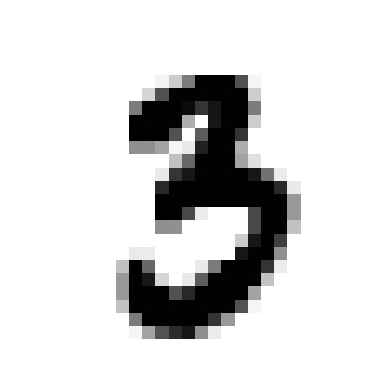

In [37]:
n = 890
some_data = X_train[n]
pred = ovo_clf.predict([some_data])
print(pred)
image_plotter(n, X_train)

In [38]:
#Alright alrght we are done with SGD both OvA and OvO method of classification. Now lets usre random forest classifier:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])
#well this lucky bastard can aready handle multinomial classifications so theres no need for OvO or OvA hehe.... cheeky.

array([5], dtype=uint8)

[3]
3


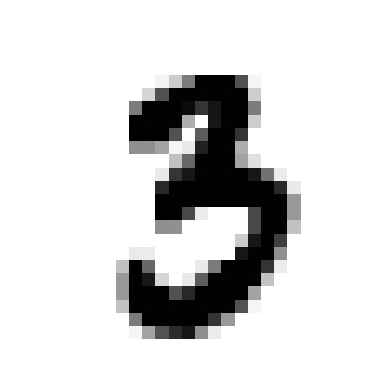

In [39]:
n = 890
some_data = X_train[n]
pred = forest_clf.predict([some_data])
print(pred)
image_plotter(n, X_train)

In [40]:
#alright let's see the performances of these guys using a ROC curve.
multi_forest_probas = cross_val_predict(forest_clf, X_train, y_train, cv=3,method="predict_proba")

In [41]:
multi_forest_probas

array([[0.  , 0.02, 0.02, ..., 0.  , 0.01, 0.01],
       [0.99, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.02, ..., 0.06, 0.02, 0.07],
       ...,
       [0.  , 0.  , 0.  , ..., 0.01, 0.01, 0.05],
       [0.03, 0.02, 0.04, ..., 0.  , 0.01, 0.  ],
       [0.02, 0.01, 0.04, ..., 0.04, 0.72, 0.06]])

In [42]:
cross_val_score(ovo_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.91545, 0.9131 , 0.92045])

In [43]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")
#well not bad but it can be better if we just scale the inputs

array([0.87365, 0.85835, 0.8689 ])

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [45]:
#whew.... well there's that now we check for errors 
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

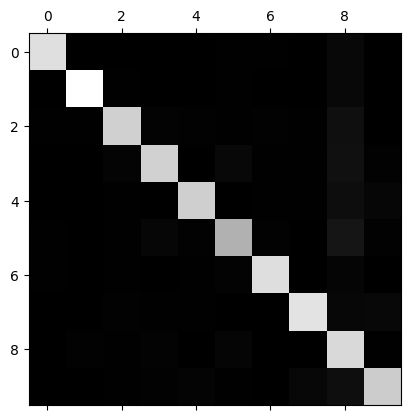

In [46]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [47]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
#Now let’s fill the diagonal with zeros to keep only the errors, and let’s plot the result:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

SyntaxError: invalid syntax (2855404546.py, line 6)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_digits(images, images_per_row=5):
    """
    Plot a grid of images.

    Parameters:
        images (numpy array): An array of images to plot. The shape should be (num_images, image_height, image_width).
        images_per_row (int): Number of images to display per row in the grid.

    Returns:
        None
    """
    num_images = images.shape[0]
    num_rows = (num_images - 1) // images_per_row + 1

    # Create a large subplot for the entire grid of images
    plt.figure(figsize=(images_per_row, num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, images_per_row, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='binary', interpolation='nearest')
        plt.axis('off')

# Example usage:
# Assuming you have X_aa, X_ab, X_ba, X_bb defined as arrays of images (num_images, image_height, image_width)
# cl_a and cl_b are the class labels
# plot_digits(X_aa[:25], images_per_row=5)
# plt.show()


In [ ]:
cl_a, cl_b = 5, 8
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plot_digits(X_aa[:25], images_per_row=5)
plt.show()
plot_digits(X_ab[:25], images_per_row=5)
plt.show()
plot_digits(X_ba[:25], images_per_row=5)
plt.show()
plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [ ]:
 plot_digits(X_aa[:25], images_per_row=5)

In [ ]:
#Multilabel Classification
#Well now we are classsifying based on more than one label usking k-nearest neighbour 
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)#first label
y_train_odd = (y_train % 2 == 1)#second label
y_multilabel = np.c_[y_train_large, y_train_odd]#combined label
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)#trained model


In [ ]:
n = 890
some_data = X_train[n]
pred = knn_clf.predict([some_data])
print(pred)
image_plotter(n, X_train)
#well mf works we know the number is three i.e it is not large and its odd: [0,1]

In [ ]:
#Alright alright not so fast knn we must evaluate you too
from sklearn.metrics import f1_score
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")
#wow easy!!

In [ ]:
#finally Multioutput Classification
#The last type of classification task we are going to discuss here is called multioutputmulticlass classification (or simply multioutput classification). It is simply a generaliza‐
#tion of multilabel classification where each label can be multiclass (i.e., it can have
#more than two possible values).



#to demonstrate this we'll be using a noisy picture just polute the mnist images
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test


In [ ]:
image_plotter(1, X_test_mod)

In [ ]:
#yikes...
knn_clf.fit(X_train_mod, y_train_mod)

In [ ]:
clean_digit = knn_clf.predict([X_test_mod[1]])
plot_digits(clean_digit)

In [50]:
test_data = pd.read_csv("test_digits.csv")

In [52]:
for column in test_data.columns:
    print(column, " : ",test_data[column].isnull().sum())

pixel0  :  0
pixel1  :  0
pixel2  :  0
pixel3  :  0
pixel4  :  0
pixel5  :  0
pixel6  :  0
pixel7  :  0
pixel8  :  0
pixel9  :  0
pixel10  :  0
pixel11  :  0
pixel12  :  0
pixel13  :  0
pixel14  :  0
pixel15  :  0
pixel16  :  0
pixel17  :  0
pixel18  :  0
pixel19  :  0
pixel20  :  0
pixel21  :  0
pixel22  :  0
pixel23  :  0
pixel24  :  0
pixel25  :  0
pixel26  :  0
pixel27  :  0
pixel28  :  0
pixel29  :  0
pixel30  :  0
pixel31  :  0
pixel32  :  0
pixel33  :  0
pixel34  :  0
pixel35  :  0
pixel36  :  0
pixel37  :  0
pixel38  :  0
pixel39  :  0
pixel40  :  0
pixel41  :  0
pixel42  :  0
pixel43  :  0
pixel44  :  0
pixel45  :  0
pixel46  :  0
pixel47  :  0
pixel48  :  0
pixel49  :  0
pixel50  :  0
pixel51  :  0
pixel52  :  0
pixel53  :  0
pixel54  :  0
pixel55  :  0
pixel56  :  0
pixel57  :  0
pixel58  :  0
pixel59  :  0
pixel60  :  0
pixel61  :  0
pixel62  :  0
pixel63  :  0
pixel64  :  0
pixel65  :  0
pixel66  :  0
pixel67  :  0
pixel68  :  0
pixel69  :  0
pixel70  :  0
pixel71  :  0
pi

In [53]:
sgd_clf = sgd_clf.fit( X_train_scaled, y_train)

In [54]:
s_predictions = sgd_clf.predict(test_data)

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(


In [55]:
s_predictions

array([2, 0, 9, ..., 3, 9, 2], dtype=uint8)

In [59]:
n = 2
some_data = test_data.loc[n]
pred = sgd_clf.predict([some_data])
print(pred)
image_plotter(n, test_data)

[9]
4


KeyError: 2

In [87]:
df = pd.DataFrame({'ImageId': np.arange(1,len(s_predictions)+1, 1), 'Label': s_predictions})
# Save the DataFrame to a CSV file with headers
df.to_csv('digits_Submission.csv', index=False)

In [80]:
y[0]

5

In [81]:
X_train_scaled = scaler.fit_transform(X.astype(np.float64))

In [82]:
sgd_clf = sgd_clf.fit( X, y)

In [86]:
s_predictions = sgd_clf.predict(test_data.to_numpy())

In [85]:
X.shape

(70000, 784)